# TUT

In [1]:
# Automatically reload modules before entering the execution of code typed at 
# the IPython prompt
%load_ext autoreload
%autoreload 2

In [3]:
# Import used libraries

import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import librosa
import torch

torch.manual_seed(0)

print(f"{pd.__name__} version: {pd.__version__}")
print(f"{matplotlib.__name__} version: {matplotlib.__version__}")
print(f"{librosa.__name__} version: {librosa.__version__}")
print(f"{torch.__name__} version: {torch.__version__}")

pandas version: 2.1.2
matplotlib version: 3.8.3
librosa version: 0.10.2.post1
torch version: 2.4.0


In [4]:
from yoho.utils import AudioFile

def plot_melspectrogram(
    audio: AudioFile,
    n_mels: int = 40,
    win_len: float = 1.00,
    hop_len: float = 1.00,
):
    """
    Plots the Mel spectrogram.
    """
    plt.figure(figsize=(10, 4))
    plt.title(f"Mel spectrogram")
    librosa.display.specshow(
        data=audio.mel_spectrogram(
            n_mels=n_mels, win_len=win_len, hop_len=hop_len
        ),
        sr=audio.sr,
        x_axis="frames",
        y_axis="mel",
    )
    plt.colorbar(format="%+2.0f dB")
    plt.tight_layout()
    plt.show()

## TUT Dataset

In [5]:
from yoho.utils import AudioFile, TUTDataset

In [6]:
N_MELS = 40
HOP_MS = 10
WIN_MS = 40

tut_train = TUTDataset(
    audios=[
        audioclip
        for _, audio in enumerate(
            AudioFile(filepath=file.filepath, labels=eval(file.events))
            for _, file in pd.read_csv(
                "./data/processed/TUT/TUT-sound-events-2017-development.csv"
            ).iterrows()
        )
        for audioclip in audio.subdivide(win_len=2.56, hop_len=1.96)
    ]
)

tut_eval = TUTDataset(
    audios=[
        audioclip
        for _, audio in enumerate(
            AudioFile(filepath=file.filepath, labels=eval(file.events))
            for _, file in pd.read_csv(
                "./data/processed/TUT/TUT-sound-events-2017-evaluation.csv"
            ).iterrows()
        )
        for audioclip in audio.subdivide(win_len=2.56, hop_len=1.96)
    ]
)

print(f"Number of audio clips in the train dataset: {len(tut_train)}")
print(f"Duration of each audio clips: {tut_train.audios[0].duration} seconds")
print(f"Sampling rate of each audio clips: {tut_train.audios[0].sr} Hz")

Number of audio clips in the train dataset: 2805
Duration of each audio clips: 2.56 seconds
Sampling rate of each audio clips: 44100 Hz


## Data generator

In [7]:
from yoho.utils import YOHODataGenerator

In [8]:
train_dataloader = YOHODataGenerator(tut_train, batch_size=32, shuffle=True)

train_features, train_labels = next(iter(train_dataloader))

print(f"Train features shape: {train_features.shape}")
print(f"Train labels shape: {train_labels.shape}")

Train features shape: torch.Size([32, 1, 40, 257])
Train labels shape: torch.Size([32, 18, 9])


### Data augmentation

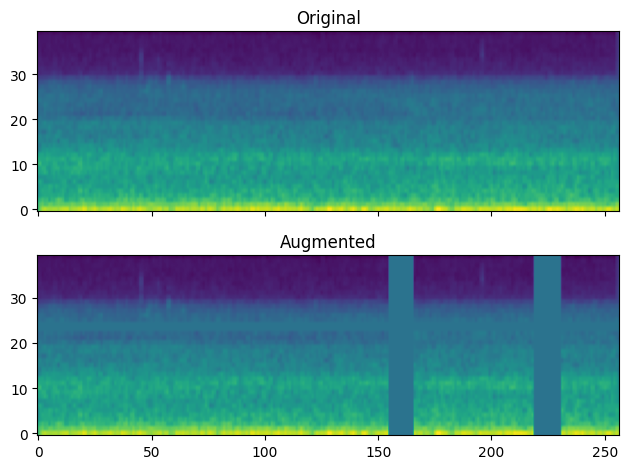

In [9]:
from torchvision.transforms import v2
from torchaudio.transforms import TimeMasking, FrequencyMasking

transforms = v2.Compose([
    FrequencyMasking(freq_mask_param=8),
    TimeMasking(time_mask_param=25),
    TimeMasking(time_mask_param=25),
])

time_masking = TimeMasking(time_mask_param=25)
freq_masking = FrequencyMasking(freq_mask_param=8)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True)
ax[0].set_title("Original")
ax[0].imshow(train_features[0][0], origin="lower", aspect="auto")
ax[1].set_title("Augmented")
ax[1].imshow(transforms(train_features[0])[0], origin="lower", aspect="auto")
fig.tight_layout()

## YOHO model

In [10]:
from torchsummary import summary

from yoho.models import YOHO
from yoho.train import get_device

# Get the available device (cuda, mps or cpu)
device = get_device()

# Define the model
model = YOHO(input_shape=(1, 40, 257), n_classes=6).to(device)

summary(
    YOHO(input_shape=(1, 40, 257), n_classes=6),
    input_size=(1, 40, 257),
    batch_size=32,
)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [32, 32, 20, 129]             288
       BatchNorm2d-2          [32, 32, 20, 129]              64
              ReLU-3          [32, 32, 20, 129]               0
            Conv2d-4          [32, 32, 20, 129]             288
       BatchNorm2d-5          [32, 32, 20, 129]              64
              ReLU-6          [32, 32, 20, 129]               0
            Conv2d-7          [32, 64, 20, 129]           2,112
       BatchNorm2d-8          [32, 64, 20, 129]             128
              ReLU-9          [32, 64, 20, 129]               0
          Dropout-10          [32, 64, 20, 129]               0
DepthwiseSeparableConv-11          [32, 64, 20, 129]               0
           Conv2d-12           [32, 64, 10, 65]             576
      BatchNorm2d-13           [32, 64, 10, 65]             128
             ReLU-14           [32

## Training

In [11]:
from yoho.train import load_checkpoint, train_model

# Get the optimizer
optimizer = model.get_optimizer()

# Load the model checkpoint if it exists
model, optimizer, start_epoch, _ = load_checkpoint(model, optimizer)

EPOCHS = 60
# train_model(
#        model=model,
#        train_loader=train_dataloader,
#        val_loader=tut_eval,
#        num_epochs=EPOCHS,
#        start_epoch=start_epoch,
#    )
model.load("./models/checkpoint.pth.tar", device)

/home/enstit/jupyterlab-notebooks/YOHO24/yoho/models.py:249: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


## Evaluation

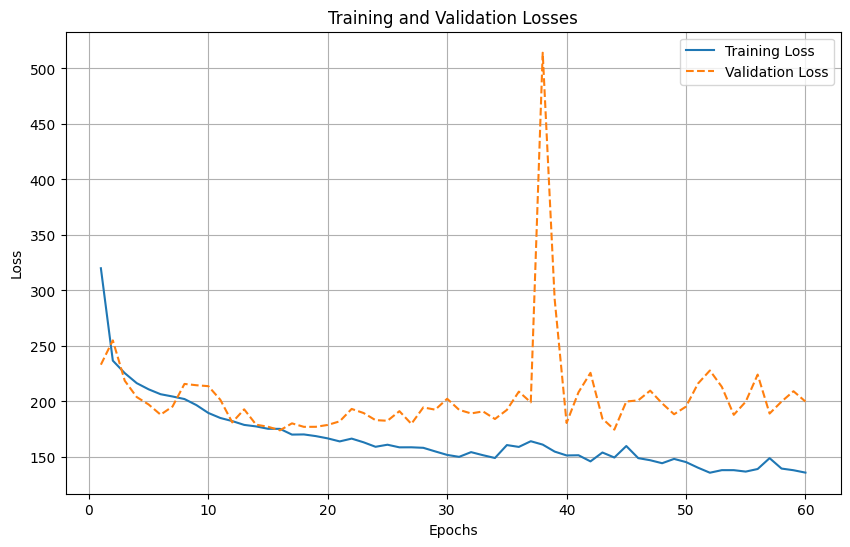

In [12]:
import json
import matplotlib.pyplot as plt

# Path to the losses.json file:

# Load the losses.json file
with open("./models/losses.json", "r") as f:
    losses = json.load(f)

# Extract epochs, train_loss, and val_loss
epochs = []
train_losses = []
val_losses = []

for epoch, metrics in losses.items():
    epochs.append(int(epoch))
    train_losses.append(metrics["train_loss"])
    val_losses.append(metrics["val_loss"])

# Sort the data by epochs to ensure correct plotting
epochs, train_losses, val_losses = zip(*sorted(zip(epochs, train_losses, val_losses)))


# Plot the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label="Training Loss")
plt.plot(epochs, val_losses, label="Validation Loss", linestyle="--")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Losses")
plt.legend()
plt.grid(True)
plt.show()

In [13]:
y_pred = model(train_features)

In [14]:
import tensorflow as tf

def my_loss_fn(y_true, y_pred):

  squared_difference = tf.square(y_true - y_pred)

  ss_True = squared_difference[:, :, 0] * 0 + 1

  ss_0 = y_true[:, :, 0]
  ss_1 = y_true[:, :, 3]
  ss_2 = y_true[:, :, 6]
  ss_3 = y_true[:, :, 9]
  ss_4 = y_true[:, :, 12]
  ss_5 = y_true[:, :, 15]

  sss = tf.stack((ss_True, ss_0, ss_0,
                  ss_True, ss_1, ss_1,
                  ss_True, ss_2, ss_2,
                  ss_True, ss_3, ss_3,
                  ss_True, ss_4, ss_4,
                  ss_True, ss_5, ss_5), axis = 2)
  
  squared_difference =  tf.multiply(squared_difference, sss)

  return tf.reduce_sum(squared_difference, axis=[-1, -2])  # Note the `axis=-1`

In [15]:
def custom_loss(target, output):
    """
    Custom loss function to compute the sum squared error.

    Parameters:
    target (torch.Tensor): The target tensor with shape (batch, 18, 9).
    output (torch.Tensor): The output of the neural network with shape (batch, 18, 9).

    Returns:
    torch.Tensor: The computed loss.
    """
    # Extract class, start point, and end point from the output and target

    output_class = output[:, 0::3, :]
    output_start = output[:, 1::3, :]
    output_end = output[:, 2::3, :]

    target_class = target[:, 0::3, :]
    target_start = target[:, 1::3, :]
    target_end = target[:, 2::3, :]

    # Determine the presence of the class
    class_present = (target_class > 0).float()

    # Compute squared differences for the class, start, and end points
    error = (
        (output_class - target_class).pow(2)
        + (output_start - target_start).pow(2) * class_present
        + (output_end - target_end).pow(2) * class_present
    ).sum(dim=[1, 2])

    return error

In [16]:
import numpy as np

# Paper loss
my_loss_fn(
    np.swapaxes(train_labels.detach().numpy(), 1, 2),
    np.swapaxes(y_pred.detach().numpy(), 1, 2),
).numpy()

array([ 0.34832959,  1.23106846,  6.97433182,  0.23521577,  0.25063906,
        1.35295884,  8.00009064,  0.35719803,  0.13490441,  0.30040405,
        7.53357062,  0.90390075,  6.41291488,  0.11828633, 17.7201847 ,
        5.81342085,  8.01577839,  8.43451848,  1.54351864,  0.06574996,
        8.92336549,  0.29480859,  4.3154544 ,  8.19419778,  4.43992416,
        0.88803025,  7.91324244,  7.42276271,  8.17070829,  2.88013413,
       15.9086202 ,  2.49160197])

In [17]:
custom_loss(
    train_labels,
    y_pred,
)

tensor([ 0.3483,  1.2311,  6.9743,  0.2352,  0.2506,  1.3530,  8.0001,  0.3572,
         0.1349,  0.3004,  7.5336,  0.9039,  6.4129,  0.1183, 17.7202,  5.8134,
         8.0158,  8.4345,  1.5435,  0.0657,  8.9234,  0.2948,  4.3155,  8.1942,
         4.4399,  0.8880,  7.9132,  7.4228,  8.1707,  2.8801, 15.9086,  2.4916],
       dtype=torch.float64, grad_fn=<SumBackward1>)

In [18]:
from yoho.losses import YOHOLoss

# Our implemented loss
yoho_loss = YOHOLoss()
yoho_loss(
    y_pred,
    train_labels,
)

tensor(147.5898, dtype=torch.float64, grad_fn=<SumBackward0>)